#  NAIVE BAYES SPAM FILTER
### CMSC 197 Machine Problem 3

### Karielle Faith Cirunay
github link: https://github.com/Kariellecirunay/CMSC-197

# PREPROCESSING

In [96]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from email import policy
from email.parser import BytesParser
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter 

### file and folder path

In [97]:
data_path = 'MP3-Naive Bayes Spam Filter/trec06p-cs280/trec06p-cs280/data' 
label_file = 'MP3-Naive Bayes Spam Filter/trec06p-cs280/trec06p-cs280/labels.txt'  
stopWords_file = 'MP3-Naive Bayes Spam Filter/stop_words.txt'

### Remove stopwords using stop_words.txt

In [98]:
stop_words_df = pd.read_csv(stopWords_file, header=None)
stop_words = set(stop_words_df[0].tolist())

### Function to remove unnecessary and stop words

In [99]:
def clean_email_body(email_body, stop_words):
    # Remove punctuation and alphanumeric characters 
    cleaned_body = re.sub(r'[^a-zA-Z\s]', '', email_body)  
    # Convert to lowercase and split into words
    words = cleaned_body.lower().split()
    
    # Remove stop words  
    filtered_words = [word for word in words if word not in stop_words]
    # Join words back into a cleaned string
    return ' '.join(filtered_words)

### Function to read and clean the emails

In [100]:
# Function to read and clean emails
def read_and_clean_emails(data_path, stop_words):
    cleaned_emails = []
    error_logs = []  

    if os.path.exists(data_path):
        folders = os.listdir(data_path)
        numeric_folders = [folder for folder in folders if folder.isdigit()]
        sorted_folders = sorted(numeric_folders, key=int)

        total_emails = 0  # Count total processed emails
        for folder in sorted_folders:
            folder_path = os.path.join(data_path, folder)
            files = os.listdir(folder_path)
            for file in files:
                file_path = os.path.join(folder_path, file)
                try:
                    with open(file_path, 'rb') as f:
                        # Parse the email
                        email = BytesParser(policy=policy.default).parse(f)
                        email_body = email.get_body(preferencelist=('plain')).get_content()
                        # Clean the email body
                        cleaned_body = clean_email_body(email_body, stop_words)
                        cleaned_emails.append((cleaned_body,folder,file))
                        total_emails += 1
                except Exception as e:
                    error_logs.append(f"Error processing file {file_path}: {e}")

        print(f"Total emails processed: {total_emails}")

        # Log errors if any
        if error_logs:
            with open("error_logs.txt", "w") as log_file:
                for log in error_logs:
                    log_file.write(log + "\n")
            print(f"Errors logged to 'error_logs.txt'")
    else:
        print(f"Directory {data_path} not found.")

    return cleaned_emails

In [101]:
# Load and clean emails
cleaned_emails = read_and_clean_emails(data_path, stop_words)

Total emails processed: 33534
Errors logged to 'error_logs.txt'


In [102]:
cleaned_emails_df = pd.DataFrame(cleaned_emails, columns=['Cleaned_Email', 'Folder','File'])
cleaned_emails_df.to_csv('cleaned_emails.csv', index=False)
cleaned_emails_df

,Cleaned_Email,Folder,File
0,mailing list queried weeks ago running set arc...,000,000
1,luxury watches buy rolex rolex cartier bvlgari...,000,001
2,academic qualifications prestigious nonacc red...,000,002
3,greetings verify subscription planfans list ch...,000,003
4,chauncey conferred luscious continued tonsillitis,000,004
...,...,...,...
33529,great news expec ted infinex ventures infx pri...,126,017
33530,oil sector going crazy weekly gift kkpt thing ...,126,018
33531,httpvdtobjdocscaninfo suffering pain depressio...,126,019
33532,prosperous future increased money earning powe...,126,020


### Function to check the cleaned email

In [103]:
# Function to read a specific email
def read_specific_email(folder, file, data_path):
    file_path = os.path.join(data_path, folder, file)
    try:
        with open(file_path, 'rb') as f:
            email = BytesParser(policy=policy.default).parse(f)
            email_body = email.get_body(preferencelist=('plain')).get_content()
            return clean_email_body(email_body, stop_words)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Reading a specific email 
specific_cleaned_email = read_specific_email('000', '001', data_path)
print(f"Cleaned Email:\n{specific_cleaned_email}")

Cleaned Email:
luxury watches buy rolex rolex cartier bvlgari frank muller patek philippe vacheron constantin lange sohne audemars piguet jaegerlecoultre iwc officine panerai breitling omega tag heuer exapmle rolex full gold daytona men fast delivery lowest prices worldwide shipping visit shop httpvvhvjksewandeatonecom


### loading label file

In [104]:
def load_labels(label_file):
    labels = {}
    with open(label_file, 'r') as file:
        for line in file:
            parts = line.strip().split()  # Split the line by whitespace
            if len(parts) >= 2:  # Ensure there are at least two parts
                label = parts[0]  
                email_id = parts[1] 
                labels[email_id] = label  # Store the label with the email ID as the key
    return labels

labels = load_labels(label_file)

### Split dataset

In [105]:
# Function to split dataset into train and test based on folder numbers
def split_dataset(data_path):
    train_folders = set([f"{i:03d}" for i in range(0, 71)])  # Folders 000-070 for training
    test_folders = set([f"{i:03d}" for i in range(71, 127)])  # Folders 071-127 for testing
    
    train_emails = []
    test_emails = []

    folders = os.listdir(data_path)
    numeric_folders = [folder for folder in folders if folder.isdigit()]
    sorted_folders = sorted(numeric_folders, key=int)
    
    for folder in sorted_folders:
        folder_path = os.path.join(data_path, folder)
        files = os.listdir(folder_path)
        for file in files:
            if folder in train_folders:
                train_emails.append((folder, file))
            elif folder in test_folders:
                test_emails.append((folder, file))
                
    # Get the count of emails in train and test sets
    train_email_count = len(train_emails)
    test_email_count = len(test_emails)
    
    print(f"Number of emails in training set: {train_email_count}")
    print(f"Number of emails in testing set: {test_email_count}")
    
    return train_emails, test_emails

# Call the function to split the dataset 
train_emails, test_emails = split_dataset(data_path)

Number of emails in training set: 21300
Number of emails in testing set: 16522


### function to attach the labels to the emails

In [106]:
def attach_labels_to_cleaned(cleaned_emails, labels):
    labeled_cleaned_emails = []
    for cleaned_body, folder, file in cleaned_emails:
        # Construct the email ID to match the format in labels
        email_id = f"../data/{folder}/{file}"  
        
        label = labels.get(email_id)  
        if label:
            labeled_cleaned_emails.append((cleaned_body, label))
        else:
            print(f"Warning: No label found for email ID '{email_id}'") 
    return labeled_cleaned_emails

In [108]:
labeled_cleaned_emails = attach_labels_to_cleaned(cleaned_emails, labels)

## Extract 10000 Common words

### function to count words

In [107]:
# Count words from ham and spam training emails
def count_words(labeled_emails):
    ham_word_counter = Counter()
    spam_word_counter = Counter()

    for email_body, label in labeled_emails:
        if label == 'ham':
            
            ham_word_counter.update(email_body.split())
        elif label == 'spam':
            spam_word_counter.update(email_body.split())

    return ham_word_counter, spam_word_counter

### function to obtain the 10000 most common words

In [109]:
# Get the most common words, limited to 10,000
def get_most_common_words(ham_word_counter, spam_word_counter):
    
    combined_counter = ham_word_counter + spam_word_counter
    most_common_words = combined_counter.most_common(10000)
    return most_common_words

### ham and spam count

In [110]:
ham_word_counter, spam_word_counter = count_words(labeled_cleaned_emails)
print(f"Ham word count: {sum(ham_word_counter.values())}")
print(f"Spam word count: {sum(spam_word_counter.values())}")

Ham word count: 2329875
Spam word count: 935038


### obtaining most common words

In [111]:
# Save the most common words to a CSV file
most_common_words = get_most_common_words(ham_word_counter, spam_word_counter)

common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
common_words_df.to_csv('most_common_words.csv', index=False)
print("Most common words saved to 'most_common_words.csv'.")
common_words_df.head (100)

Most common words saved to 'most_common_words.csv'.


,Word,Frequency
0,will,22981
1,received,10750
2,email,10030
3,list,9478
4,subject,9470
...,...,...
95,development,2935
96,item,2903
97,server,2899
98,unsubscribe,2870


In [112]:
# Get the most common words
def get_most_common_words_with_counts(ham_word_counter, spam_word_counter, n=10000):
    most_common_words = []
    
    # Combine ham and spam counts
    combined_counter = ham_word_counter + spam_word_counter
    
    for word, count in combined_counter.most_common(n):
        ham_count = ham_word_counter[word]  # Frequency in ham
        spam_count = spam_word_counter[word]  # Frequency in spam
        most_common_words.append((word, count, ham_count, spam_count))

    return most_common_words

#get the most common words along with ham and spam counts
most_common_words_with_counts = get_most_common_words_with_counts(ham_word_counter, spam_word_counter)

# Create DataFrame with the result
common_words_df = pd.DataFrame(most_common_words_with_counts, columns=['Word', 'Total_Frequency', 'Ham_Frequency', 'Spam_Frequency'])

# Save to CSV
common_words_df.to_csv('most_common_words_with_counts.csv', index=False)
print("Most common words with counts saved to 'most_common_words_with_counts.csv'.")


Most common words with counts saved to 'most_common_words_with_counts.csv'.


In [113]:
common_words_df.head(150)

,Word,Total_Frequency,Ham_Frequency,Spam_Frequency
0,will,22981,14812,8169
1,received,10750,10154,596
2,email,10030,7782,2248
3,list,9478,9078,400
4,subject,9470,9258,212
...,...,...,...,...
145,cart,2281,19,2262
146,provide,2277,1446,831
147,handyboard,2272,2272,0
148,second,2271,1828,443


# CREATING FEATURE MATRICES

In [114]:
vocabulary = common_words_df['Word'].tolist()[:10000]  # Get the top 10,000 words

### function to create the feature matrices

In [115]:
# create feature matrices for ham and spam emails
def create_feature_matrix(labeled_emails, vocabulary):
    num_emails = len(labeled_emails)
    feature_matrix = np.zeros((num_emails, len(vocabulary)), dtype=int)

    word_index = {word: idx for idx, word in enumerate(vocabulary)}
    
    for i, (email_body, label) in enumerate(labeled_emails):
        words = set(email_body.split())
        for word in words:
            if word in word_index:
                feature_matrix[i, word_index[word]] = 1  # Mark presence of the word

    return feature_matrix

### split labeled cleaned emails

In [116]:
# Split labeled cleaned emails into ham and spam based on their labels
ham_emails = [(body, label) for body, label in labeled_cleaned_emails if label == 'ham']
spam_emails = [(body, label) for body, label in labeled_cleaned_emails if label == 'spam']

# create the feature matrices
ham_feature_matrix = create_feature_matrix(ham_emails, vocabulary)
spam_feature_matrix = create_feature_matrix(spam_emails, vocabulary)

# Print the shape of the feature matrices
print(f"Ham Feature Matrix Shape: {ham_feature_matrix.shape}")
print(f"Spam Feature Matrix Shape: {spam_feature_matrix.shape}")

Ham Feature Matrix Shape: (12659, 10000)
Spam Feature Matrix Shape: (20875, 10000)


# COMPUTING THE PRIORS

In [117]:
N_ham = ham_feature_matrix.shape[0]  # Number of ham emails
N_spam = spam_feature_matrix.shape[0]  # Number of spam emails

# Total number of documents
N_doc = N_ham + N_spam

# Calculate prior probabilities
P_ham = N_ham / N_doc
P_spam = N_spam / N_doc

# Display the results
print(f"Number of Ham Emails: {N_ham}")
print(f"Number of Spam Emails: {N_spam}")
print(f"Total Number of Emails: {N_doc}")
print(f"Prior Probability P(c=ham): {P_ham:.4f}")
print(f"Prior Probability P(c=spam): {P_spam:.4f}")

Number of Ham Emails: 12659
Number of Spam Emails: 20875
Total Number of Emails: 33534
Prior Probability P(c=ham): 0.3775
Prior Probability P(c=spam): 0.6225


# CALCULATING THE LIKELIHOOD

In [118]:
# Vocabulary size: the union of all unique words in both spam and ham
vocabulary = set(spam_word_counter.keys()).union(set(ham_word_counter.keys()))
V = len(vocabulary)

# Laplace smoothing parameter
lambda_smoothing = 1

# Total number of words in spam and ham emails
total_spam_words = sum(spam_word_counter.values())
total_ham_words = sum(ham_word_counter.values())

# Function to compute likelihood with Laplace smoothing
def compute_likelihood(word, word_counts, total_words, V, lambda_smoothing):
    count = word_counts.get(word, 0)  # Get the count of the word or 0 if not found
    return (count + lambda_smoothing) / (total_words + lambda_smoothing * V)

# Compute likelihoods for all words in the vocabulary
spam_likelihoods = {}
ham_likelihoods = {}

for word in vocabulary:
    spam_likelihoods[word] = compute_likelihood(word, spam_word_counter, total_spam_words, V, lambda_smoothing)
    ham_likelihoods[word] = compute_likelihood(word, ham_word_counter, total_ham_words, V, lambda_smoothing)

# Display the likelihoods for each word
print("Word Likelihoods (P(word|spam)):")
for word, likelihood in list(spam_likelihoods.items())[:50]:
    print(f"{word}: {likelihood:.10f}")

print("\nWord Likelihoods (P(word|ham)):")
for word, likelihood in list(ham_likelihoods.items())[:50]:
    print(f"{word}: {likelihood:.10f}")

Word Likelihoods (P(word|spam)):
sheets: 0.0001581946
clasp: 0.0000045721
misprinted: 0.0000009144
fafcccbfaolcom: 0.0000009144
edtgmt: 0.0000009144
unita: 0.0000045721
aaabpbuaaaaegakagaaacgbaaaagoaaemacayaaaagqeanoavweqabaaywftfgaawei: 0.0000009144
compart: 0.0000009144
tonasket: 0.0000009144
paramountcopyrightcompliancecom: 0.0000009144
petes: 0.0000009144
payasyougo: 0.0000009144
skhpxslevwffwwpqucmrkxvqpiozampfbglitbcuazkvyddydaxvmr: 0.0000009144
xquotprixquot: 0.0000009144
brainwash: 0.0000064009
wner: 0.0000027433
americabr: 0.0000009144
todate: 0.0000009144
httpheawwwharvardeduswolk: 0.0000009144
mailtomariekehenselnl: 0.0000009144
rotunda: 0.0000009144
polanic: 0.0000009144
aaataqmabwaaapwcaadrkaaaaeaaaalqehaaaaaakawuaaibalgdswjyaycainauqc: 0.0000009144
repatriat: 0.0000137163
imbc: 0.0000009144
hipotecarios: 0.0000009144
jleecsecuhkeduhk: 0.0000009144
mystery: 0.0000009144
speciation: 0.0000009144
bqaaayaameaaahcaaamwuaahqaaaaaamfaaaobwaarqqaapgiaabbqaadaaaaaaazgua: 0.0000009

# CLASSIFYING THE EMAILS

## Function to classify emails

In [119]:
def classify_email(email_body, spam_likelihoods, ham_likelihoods, P_ham, P_spam):
    words = email_body.split()
    
    # Calculate log probabilities
    log_prob_ham = np.log(P_ham)
    log_prob_spam = np.log(P_spam)

    for word in words:
        if word in spam_likelihoods:
            log_prob_spam += np.log(spam_likelihoods[word])
        else:
            # If not in the vocabulary, we can ignore or assume a small likelihood
            log_prob_spam += np.log(lambda_smoothing / (total_spam_words + lambda_smoothing * V))

        if word in ham_likelihoods:
            log_prob_ham += np.log(ham_likelihoods[word])
        else:
            log_prob_ham += np.log(lambda_smoothing / (total_ham_words + lambda_smoothing * V))

    return log_prob_ham, log_prob_spam

### Classifying all the cleaned emails

In [120]:
# Classify all cleaned emails
classified_emails = []

for cleaned_body, label in labeled_cleaned_emails:
    log_prob_ham, log_prob_spam = classify_email(cleaned_body, spam_likelihoods, ham_likelihoods, P_ham, P_spam)
    
    # Determine the classification
    if log_prob_spam > log_prob_ham:
        classification = 'spam'
    else:
        classification = 'ham'
        
    classified_emails.append((cleaned_body, classification))

In [121]:
classified_emails_df = pd.DataFrame(classified_emails, columns=['Cleaned_Email', 'Classification'])
classified_emails_df.to_csv('classified_emails.csv', index=False)
print("Classified emails saved to 'classified_emails.csv'.")

Classified emails saved to 'classified_emails.csv'.


In [122]:
classified_emails_df.head(150)

,Cleaned_Email,Classification
0,mailing list queried weeks ago running set arc...,ham
1,luxury watches buy rolex rolex cartier bvlgari...,spam
2,academic qualifications prestigious nonacc red...,spam
3,greetings verify subscription planfans list ch...,ham
4,chauncey conferred luscious continued tonsillitis,spam
...,...,...
145,websites buy medication erectile difficulties ...,spam
146,introduce freshest session httpqchangemeoscom ...,spam
147,will lend money special arrangements dozens to...,spam
148,,spam


# TESTING THE CLASSIFIER

### SPAM EMAIL

In [123]:
email_example = """
Hello there, we are offering an exclusive discount on all products! 
Visit our website today to avail of this limited-time offer.
"""

# Clean the message 
cleaned_your_message = clean_email_body(email_example, stop_words)

# Classify the cleaned message using the classify_email function
log_prob_ham, log_prob_spam = classify_email(cleaned_your_message, spam_likelihoods, ham_likelihoods, P_ham, P_spam)

# Determine which class it belongs to based on higher probability
if log_prob_ham > log_prob_spam:
    print("The message is classified as Ham.")
else:
    print("The message is classified as Spam.")


The message is classified as Spam.


### HAM EMAIL

In [124]:
email_example = """
Hi team,

I hope you are doing well. Just a quick reminder that we have a meeting scheduled tomorrow at 10 AM. 
Please make sure to review the agenda beforehand, and let me know if you have any updates to share.

Best regards,
John
"""

# Clean the message 
cleaned_your_message = clean_email_body(email_example, stop_words)

# Classify the cleaned message using the classify_email function
log_prob_ham, log_prob_spam = classify_email(cleaned_your_message, spam_likelihoods, ham_likelihoods, P_ham, P_spam)

# Determine which class it belongs to based on higher probability
if log_prob_ham > log_prob_spam:
    print("The message is classified as Ham.")
else:
    print("The message is classified as Spam.")

The message is classified as Ham.


# PERFORMANCE EVALUATION

### compute TP,TN,FP,FN

In [125]:
# Function to calculate metrics
def calculate_metrics(predictions):
    TP = FP = TN = FN = 0
    
    # Calculate TN, FN, FP, TP
    for actual, predicted in predictions:
        if actual == 'spam' and predicted == 'spam':
            TP += 1
        elif actual == 'spam' and predicted == 'ham':
            FN += 1
        elif actual == 'ham' and predicted == 'spam':
            FP += 1
        elif actual == 'ham' and predicted == 'ham':
            TN += 1

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0      

    return accuracy, precision, recall

### computing Accuracy, Recall,Precision

In [126]:
cleaned_predictions = []
# Classify all cleaned emails
for cleaned_body, actual_label in labeled_cleaned_emails:
    log_prob_ham, log_prob_spam = classify_email(cleaned_body, spam_likelihoods, ham_likelihoods, P_ham, P_spam)
    predicted_label = 'spam' if log_prob_spam > log_prob_ham else 'ham'
    cleaned_predictions.append((actual_label, predicted_label))

# Calculate metrics for cleaned emails
cleaned_accuracy, cleaned_precision, cleaned_recall = calculate_metrics(cleaned_predictions)

# Display the results
print(f"Accuracy: {cleaned_accuracy:.4f}")
print(f"Precision: {cleaned_precision:.4f}")
print(f"Recall: {cleaned_recall:.4f}")

Accuracy: 0.9885
Precision: 0.9924
Recall: 0.9891


# RESULTS AND DISCUSSIONS

## (1) What is the effect of removing stop words in terms of precision, recall, and accuracy? Show a plot or a table of these results.

### Obtaining original email accuracy,precision,and recall
Since we were able to obtain the accuracy,precision, and recall, we need to obtain those from the original emails so we can differentiate the effect of removing stop words and not.

In [127]:
# Function to read and clean emails for original emails
def read_emails (data_path):
    original_emails = []  
    error_logs = []  

    if os.path.exists(data_path):
        folders = os.listdir(data_path)
        numeric_folders = [folder for folder in folders if folder.isdigit()]
        sorted_folders = sorted(numeric_folders, key=int)

        total_emails = 0  # Count total processed emails
        for folder in sorted_folders:
            folder_path = os.path.join(data_path, folder)
            files = os.listdir(folder_path)
            for file in files:
                file_path = os.path.join(folder_path, file)
                try:
                    with open(file_path, 'rb') as f:
                        # Parse the email
                        email = BytesParser(policy=policy.default).parse(f)
                        email_body = email.get_body(preferencelist=('plain')).get_content()
                        
                        # Store the original email body
                        original_emails.append((email_body, folder, file))
                        total_emails += 1
                except Exception as e:
                    error_logs.append(f"Error processing file {file_path}: {e}")

        print(f"Total emails processed: {total_emails}")

        # Log errors if any
        if error_logs:
            with open("error_logs.txt", "w") as log_file:
                for log in error_logs:
                    log_file.write(log + "\n")
            print(f"Errors logged to 'error_logs.txt'")
    else:
        print(f"Directory {data_path} not found.")

    return original_emails  

# Load emails
original_emails = read_emails(data_path)

# Function to attach labels to original emails
def attach_labels_to_original(original_emails, labels):
    labeled_original_emails = []
    for original_body, folder, file in original_emails:
        # Construct the email ID to match the format in labels
        email_id = f"../data/{folder}/{file}"  
        
        label = labels.get(email_id)  
        if label:
            labeled_original_emails.append((original_body, label))
        else:
            print(f"Warning: No label found for email ID '{email_id}'") 
    return labeled_original_emails

# Attach labels to the original emails
labeled_original_emails = attach_labels_to_original(original_emails, labels)


Total emails processed: 33534
Errors logged to 'error_logs.txt'


In [128]:
original_predictions = []

# Classify all original emails (with stop words)
for original_body, folder, file in original_emails:
    # Construct the email ID to match the format in labels
    email_id = f"../data/{folder}/{file}" 
    actual_label = labels.get(email_id)  

    if actual_label is not None:
        log_prob_ham, log_prob_spam = classify_email(original_body, spam_likelihoods, ham_likelihoods, P_ham, P_spam)
        predicted_label = 'spam' if log_prob_spam > log_prob_ham else 'ham'
        original_predictions.append((actual_label, predicted_label))
    else:
        print(f"Warning: No label found for email ID '{email_id}'")

# Calculate metrics for original emails
original_accuracy, original_precision, original_recall = calculate_metrics(original_predictions)

# Display the results
print(f"Accuracy: {original_accuracy:.4f}")
print(f"Precision: {original_precision:.4f}")
print(f"Recall: {original_recall:.4f}")

Accuracy: 0.6527
Precision: 0.6419
Recall: 1.0000


### COMPARISON

In [129]:
# Prepare results for comparison
results = {
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Cleaned Emails': [cleaned_accuracy, cleaned_precision, cleaned_recall],
    'Original Emails': [original_accuracy, original_precision, original_recall]
}

results_df = pd.DataFrame(results)
results_df

,Metric,Cleaned Emails,Original Emails
0,Accuracy,0.988489,0.652681
1,Precision,0.992406,0.641882
2,Recall,0.989078,0.999952


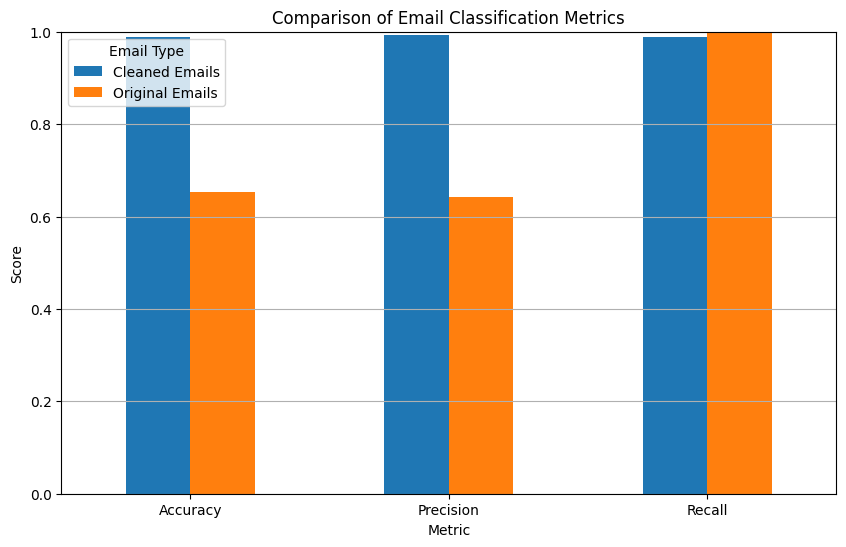

In [130]:
# Plot the results
results_df.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Email Classification Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1) 
plt.grid(axis='y')
plt.legend(title='Email Type')
plt.show()

### The effect of removing stop words lies in the computation of precision, recall, and accuracy. Removing stop words significantly increases the performance of the model that processes various emails. Therefore, removing them allows the model to focus on more significant terms in classifying the email to be spam or ham for better understanding and learning of the given text.

### In the plot, a comparison is shown between the accuracy, precision, and recall of cleaned emails, an email removed with stop words, and original emails (uncleaned emails). We can see that the score for accuracy and precision for the cleaned emails is significantly higher compared to the original email. Meanwhile, for the recall, the original email is a little higher, but the scores are closer to each other therefore, both perform the same efficiency when it comes to recall.

## (2) Experiment on the number of words used for training. Filter the dictionary to include only words occurring more than k times (1000 words, then k > 100, and k = 50 times). For example, the word “offer” appears 150 times, that means that it will be included in the dictionary.

In [131]:
# Create a vocabulary list (all words)
vocabulary = common_words_df['Word'].tolist()

# Create a dictionary from the DataFrame for frequency counts
word_freq_dict = dict(zip(common_words_df['Word'], common_words_df['Total_Frequency']))

def filter_words_by_frequency(word_freq_dict, k, condition='more'):
    
    if condition == 'more':
        filtered_dict = {word: freq for word, freq in word_freq_dict.items() if freq > k}
    elif condition == 'equal':
        filtered_dict = {word: freq for word, freq in word_freq_dict.items() if freq == k}
    else:
        raise ValueError("Condition must be 'more' or 'equal'.")
    
    # Converting the filtered dictionary to a DataFrame
    filtered_df = pd.DataFrame(filtered_dict.items(), columns=['Word', 'Frequency'])
    return filtered_df

# Filtering for different k values
filtered_k1000_df = filter_words_by_frequency(word_freq_dict, 1000, condition='more')
filtered_k100_df = filter_words_by_frequency(word_freq_dict, 100, condition='more')
filtered_k50_df = filter_words_by_frequency(word_freq_dict, 50, condition='equal')

# Print the results
print("Words occurring more than 1000 times:")
print(filtered_k1000_df)

print("\nWords occurring more than 100 times:")
print(filtered_k100_df)

print("\nWords occurring exactly 50 times:")
print(filtered_k50_df)


Words occurring more than 1000 times:
          Word  Frequency
0         will      22981
1     received      10750
2        email      10030
3         list       9478
4      subject       9470
..         ...        ...
505    college       1010
506      swath       1005
507         gt       1003
508       move       1001
509  announces       1001

[510 rows x 2 columns]

Words occurring more than 100 times:
               Word  Frequency
0              will      22981
1          received      10750
2             email      10030
3              list       9478
4           subject       9470
...             ...        ...
4866     xbeenthere        101
4867    listarchive        101
4868  listsubscribe        101
4869        concall        101
4870        beehive        101

[4871 rows x 2 columns]

Words occurring exactly 50 times:
          Word  Frequency
0    democracy         50
1         noel         50
2       ported         50
3        hayes         50
4     nicholas         50


### Words occuring more than a hundred times has the most highest number of words, followed by words occuring more than a thousand, and the least number of words is for exactly 50 times.

## (3) Discuss the results of the different parameters used for Lambda smoothing. Test it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), Evaluate performance metrics for each.

In [135]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Function to compute likelihood with Laplace smoothing
def compute_likelihood(word, word_counts, total_words, V, lambda_smoothing):
    count = word_counts.get(word, 0)  # Get the count of the word or 0 if not found
    return (count + lambda_smoothing) / (total_words + lambda_smoothing * V)

# Function to classify email based on calculated likelihoods
def classify_email(email_body, spam_likelihoods, ham_likelihoods, P_ham, P_spam, total_spam_words, total_ham_words, V, lambda_smoothing):
    words = email_body.split()
    
    # Calculate log probabilities
    log_prob_ham = np.log(P_ham)
    log_prob_spam = np.log(P_spam)

    for word in words:
        if word in spam_likelihoods:
            log_prob_spam += np.log(spam_likelihoods[word])
        else:
            log_prob_spam += np.log(lambda_smoothing / (total_spam_words + lambda_smoothing * V))

        if word in ham_likelihoods:
            log_prob_ham += np.log(ham_likelihoods[word])
        else:
            log_prob_ham += np.log(lambda_smoothing / (total_ham_words + lambda_smoothing * V))

    return 'spam' if log_prob_spam > log_prob_ham else 'ham'


# Function to evaluate for different lambda smoothing values
def evaluate_lambda_smoothing(lambdas, labeled_cleaned_emails, spam_word_counter, ham_word_counter, P_ham, P_spam, V):
    total_spam_words = sum(spam_word_counter.values())
    total_ham_words = sum(ham_word_counter.values())

    for lambda_smoothing in lambdas:
        # Compute likelihoods for each word with current λ value
        spam_likelihoods = {}
        ham_likelihoods = {}
        for word in vocabulary:
            spam_likelihoods[word] = compute_likelihood(word, spam_word_counter, total_spam_words, V, lambda_smoothing)
            ham_likelihoods[word] = compute_likelihood(word, ham_word_counter, total_ham_words, V, lambda_smoothing)

        cleaned_predictions = []
        
        # Classify all cleaned emails
        for cleaned_body, actual_label in labeled_cleaned_emails:
            predicted_label = classify_email(cleaned_body, spam_likelihoods, ham_likelihoods, P_ham, P_spam, total_spam_words, total_ham_words, V, lambda_smoothing)
            cleaned_predictions.append((actual_label, predicted_label))
        
        # Calculate metrics for the current λ value
        cleaned_accuracy, cleaned_precision, cleaned_recall = calculate_metrics(cleaned_predictions)
        
        # Display the results for the current λ
        print(f"λ = {lambda_smoothing}:")
        print(f"Accuracy: {cleaned_accuracy:.4f}")
        print(f"Precision: {cleaned_precision:.4f}")
        print(f"Recall: {cleaned_recall:.4f}")
        print('-------------------------------------------')

# Vocabulary size
vocabulary = set(spam_word_counter.keys()).union(set(ham_word_counter.keys()))
V = len(vocabulary)

# List of lambda smoothing values to evaluate
lambda_values = [2.0, 1.0, 0.5, 0.1, 0.005]

# Call the function to evaluate lambda smoothing values
evaluate_lambda_smoothing(lambda_values, labeled_cleaned_emails, spam_word_counter, ham_word_counter, P_ham, P_spam, V)


λ = 2.0:
Accuracy: 0.9866
Precision: 0.9918
Recall: 0.9867
-------------------------------------------
λ = 1.0:
Accuracy: 0.9885
Precision: 0.9924
Recall: 0.9891
-------------------------------------------
λ = 0.5:
Accuracy: 0.9904
Precision: 0.9929
Recall: 0.9917
-------------------------------------------
λ = 0.1:
Accuracy: 0.9926
Precision: 0.9938
Recall: 0.9943
-------------------------------------------
λ = 0.005:
Accuracy: 0.9935
Precision: 0.9939
Recall: 0.9956
-------------------------------------------


### We evaluate the performance metrics for different lambda values. As we can see from the result, as the lambda values become smaller, the performance metrics produces higher values. We can see that λ = 2.0 has the lowest performance metrics values, meanwhile, λ = 0.005 has the highest performance metrics. So, lambda value and performance metrics are inversely proportional to each other.

## (4) What are your recommendations to further improve the model?

### My recommendations to further improve the model is to have a balanced dataset between spam and ham to prevent biased towards the the class that dominates the majority.